In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  mean_squared_error,r2_score, mean_absolute_error

from xgboost import XGBRegressor

In [2]:
def visualize_hist(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].hist(bins=50, ax=ax[row, col])
        ax[row, col].set_title(x)

def visualize_plot(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].plot(ax=ax[row, col])
        ax[row, col].set_title(x)
        
def create_target_col(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('id')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['id','max']
    df = df.merge(fd_RUL, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['cycle'] > factor]

def plot_timeline(feature, X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', feature, 
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0) 
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(feature)
    plt.xlabel('Remaining Use fulLife')
    plt.show()
    
def remove_outlier(df):
    for col_name in df.columns:
        q1 = df[col_name].quantile(0.25)
        q3 = df[col_name].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df[col_name] = np.where(df[col_name] > fence_high, fence_high, 
                                np.where(df[col_name] < fence_low, fence_low, df[col_name]))
    return df

# EDA

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

In [5]:
# у нас нет пропущенных значений

In [6]:
df.describe()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
count,16138.000000,16138.000000,1.613800e+04,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,...,16138.000000,16138.000000,16138.000000,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04
mean,40.707894,105.548147,5.186700e+02,1.300000e+00,47.544263,521.405420,2388.096737,8143.933458,8.442581,3.000000e-02,...,23.288552,1590.582096,1409.033729,1.462000e+01,21.609795,553.359776,2388.097368,9065.461291,0.000010,6.196555e-08
std,23.395354,65.915295,6.275708e-11,3.932532e-13,0.267422,0.738252,0.072604,19.731349,0.037520,1.230304e-14,...,0.108606,6.129960,8.977073,3.044770e-12,0.001417,0.887947,0.071608,22.781362,0.002188,2.939096e-04
min,1.000000,1.000000,5.186700e+02,1.300000e+00,46.860000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,...,22.907100,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,-0.008600,-6.000000e-04
25%,20.000000,51.000000,5.186700e+02,1.300000e+00,47.350000,520.940000,2388.040000,8132.830000,8.415300,3.000000e-02,...,23.220600,1586.330000,1402.500000,1.462000e+01,21.610000,552.800000,2388.050000,9052.820000,-0.001400,-3.000000e-04
50%,42.000000,101.000000,5.186700e+02,1.300000e+00,47.520000,521.460000,2388.090000,8140.750000,8.439800,3.000000e-02,...,23.296300,1590.190000,1408.220000,1.462000e+01,21.610000,553.430000,2388.090000,9060.750000,0.000000,0.000000e+00
75%,61.000000,153.000000,5.186700e+02,1.300000e+00,47.710000,521.940000,2388.140000,8148.817500,8.466000,3.000000e-02,...,23.365600,1594.450000,1414.650000,1.462000e+01,21.610000,554.000000,2388.140000,9069.940000,0.001500,3.000000e-04
max,80.000000,362.000000,5.186700e+02,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,...,23.612700,1614.930000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,0.008700,6.000000e-04


In [7]:
last_cycles = df.groupby('id').agg({'cycle':'max'})

Text(0.5, 9.444444444444459, 'max time cycle')

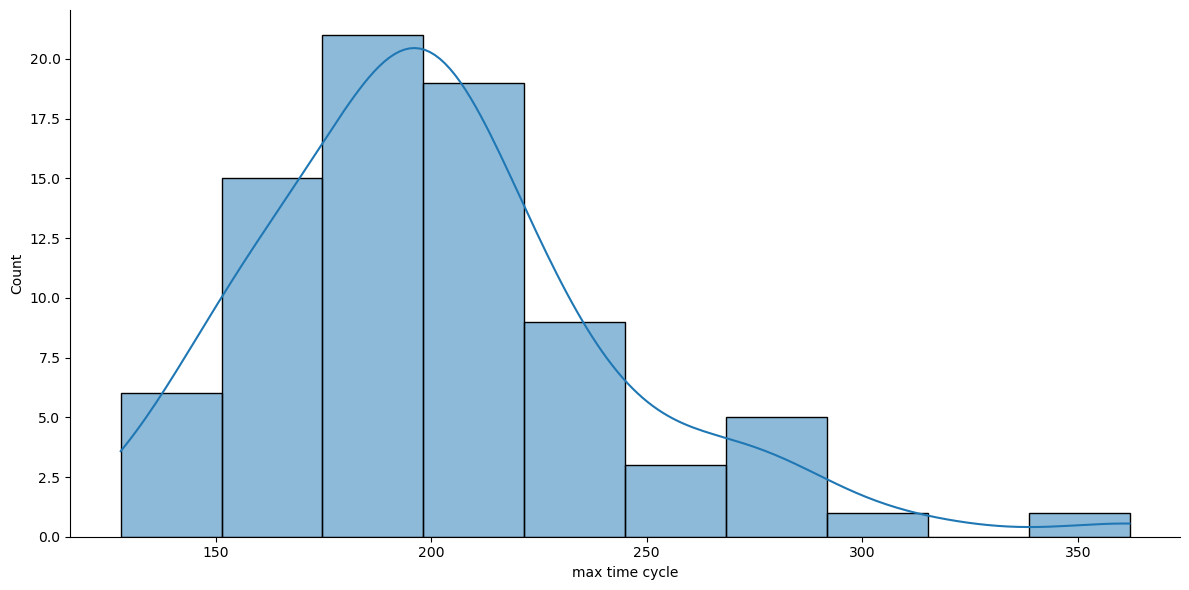

In [8]:
sns.displot(last_cycles['cycle'],kde=True,bins=10,height=6,aspect=2)
plt.xlabel('max time cycle')

In [ ]:
# попробовать в качестве бейзлайна, потом пытаться его победить

In [9]:
# в среднем проходит 180-200 циклов до того как двигатель выходит из строя

In [9]:
df_new = create_target_col(df)

In [10]:
df_new.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p14,p15,p16,p17,p18,p19,p20,s1,s2,RUL
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,191
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,190
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,189
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000,188
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,187


In [11]:
a = [1,2,3,4,5,6]
b = [1,2,3,4,5,100]

In [12]:
import scipy.stats

In [13]:
scipy.stats.spearmanr(a,b)

SignificanceResult(statistic=1.0, pvalue=0.0)

<Axes: >

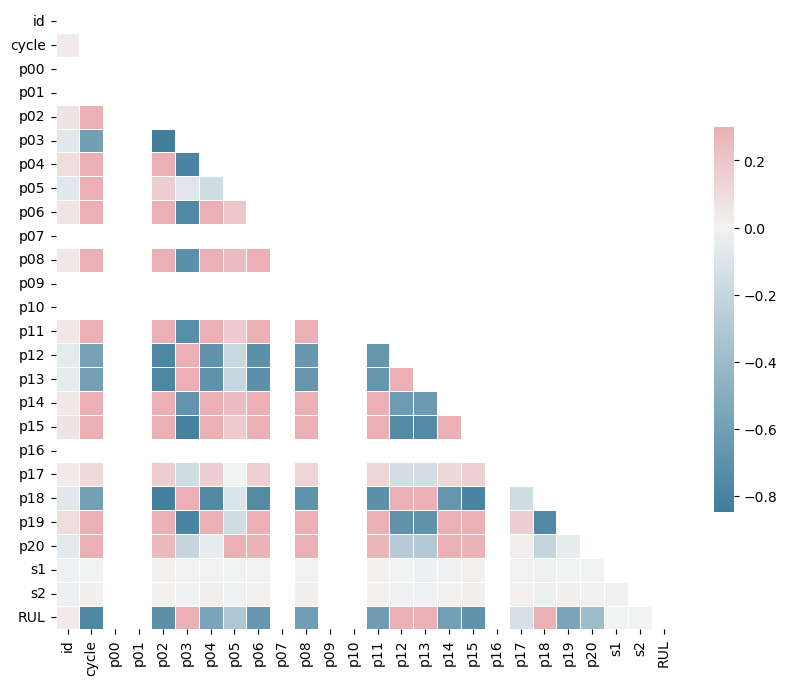

In [14]:
# Compute the correlation matrix
corr = df_new.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
# Колонки s1, s2 никак не кореллируют с таргетом. 

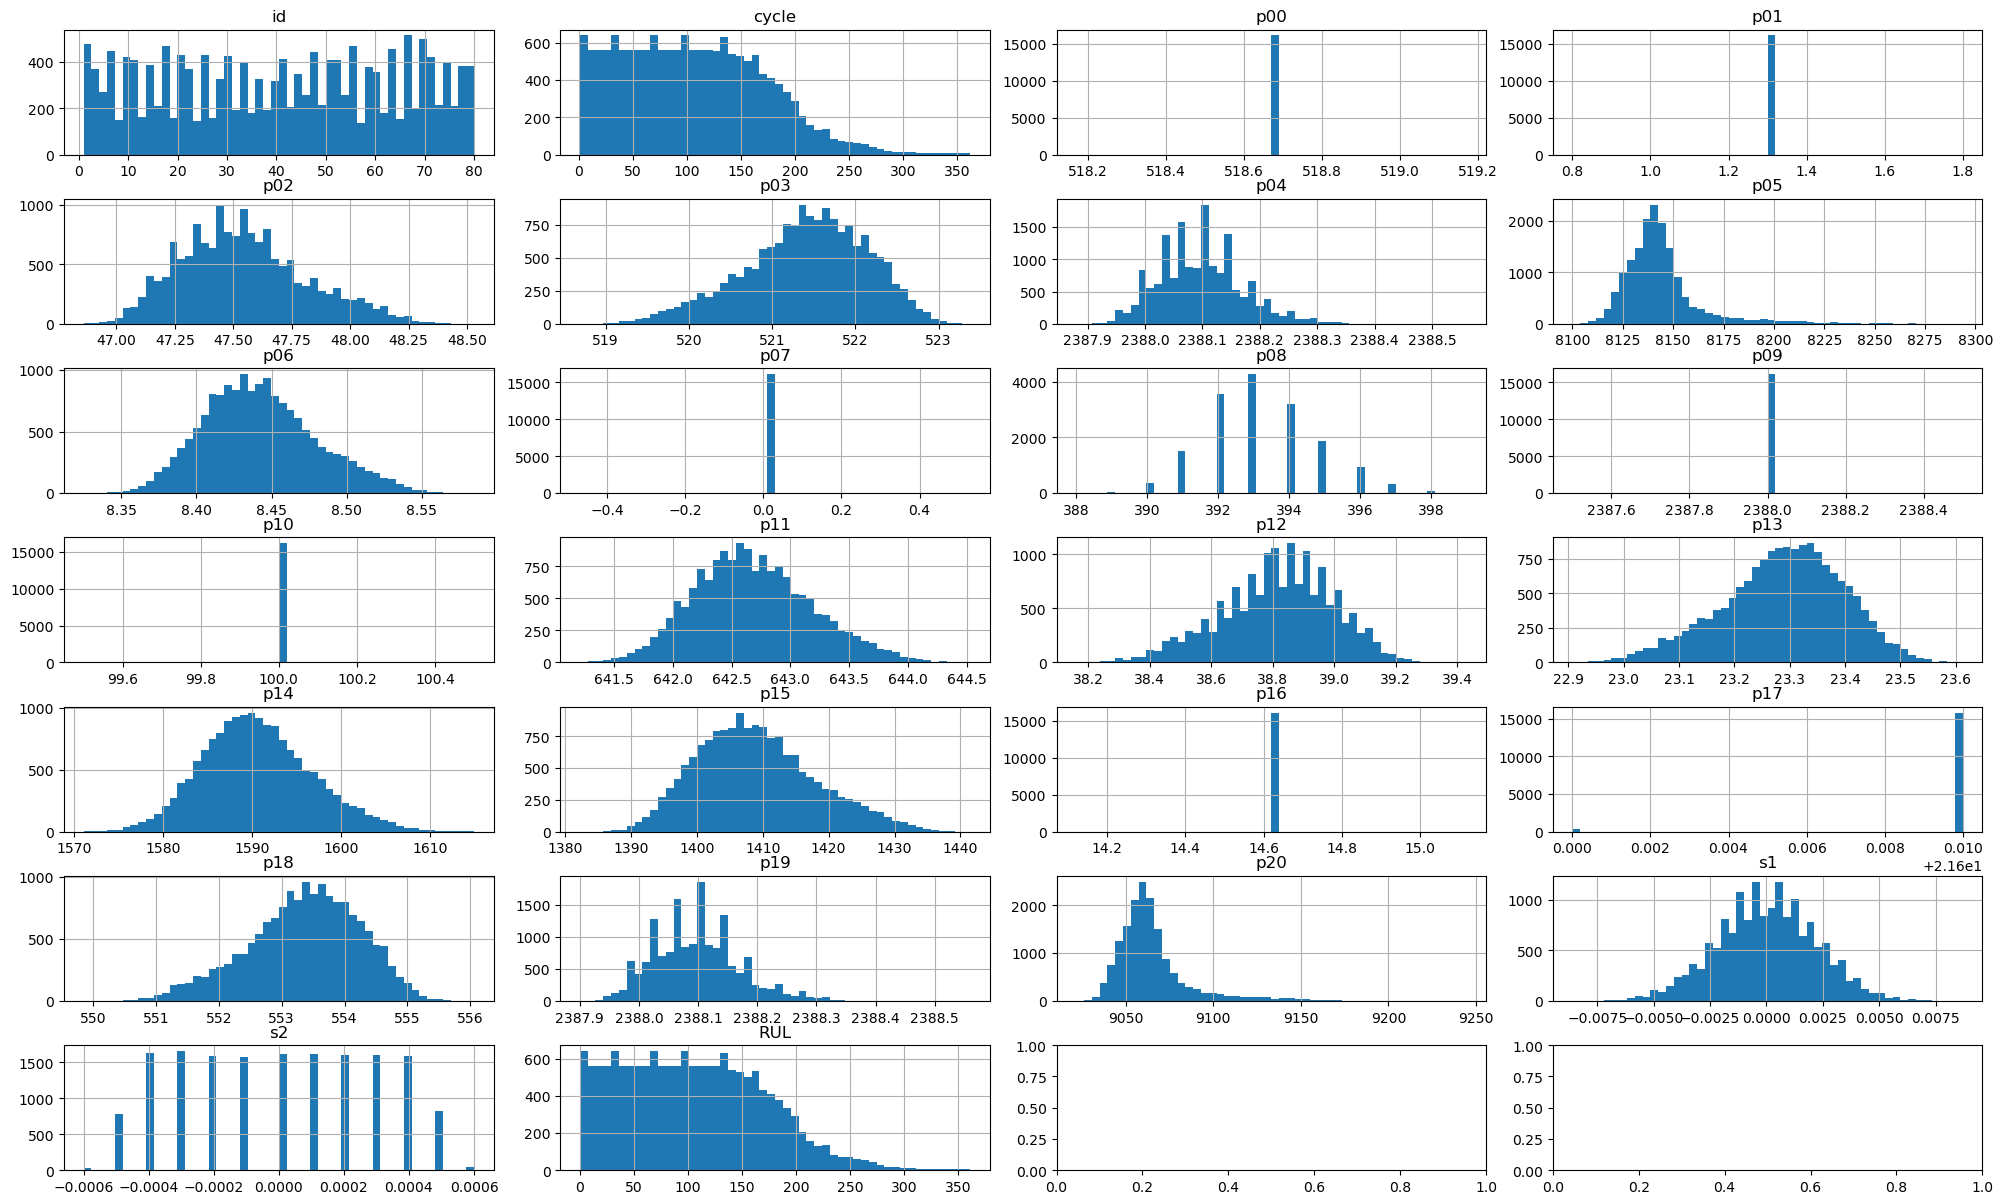

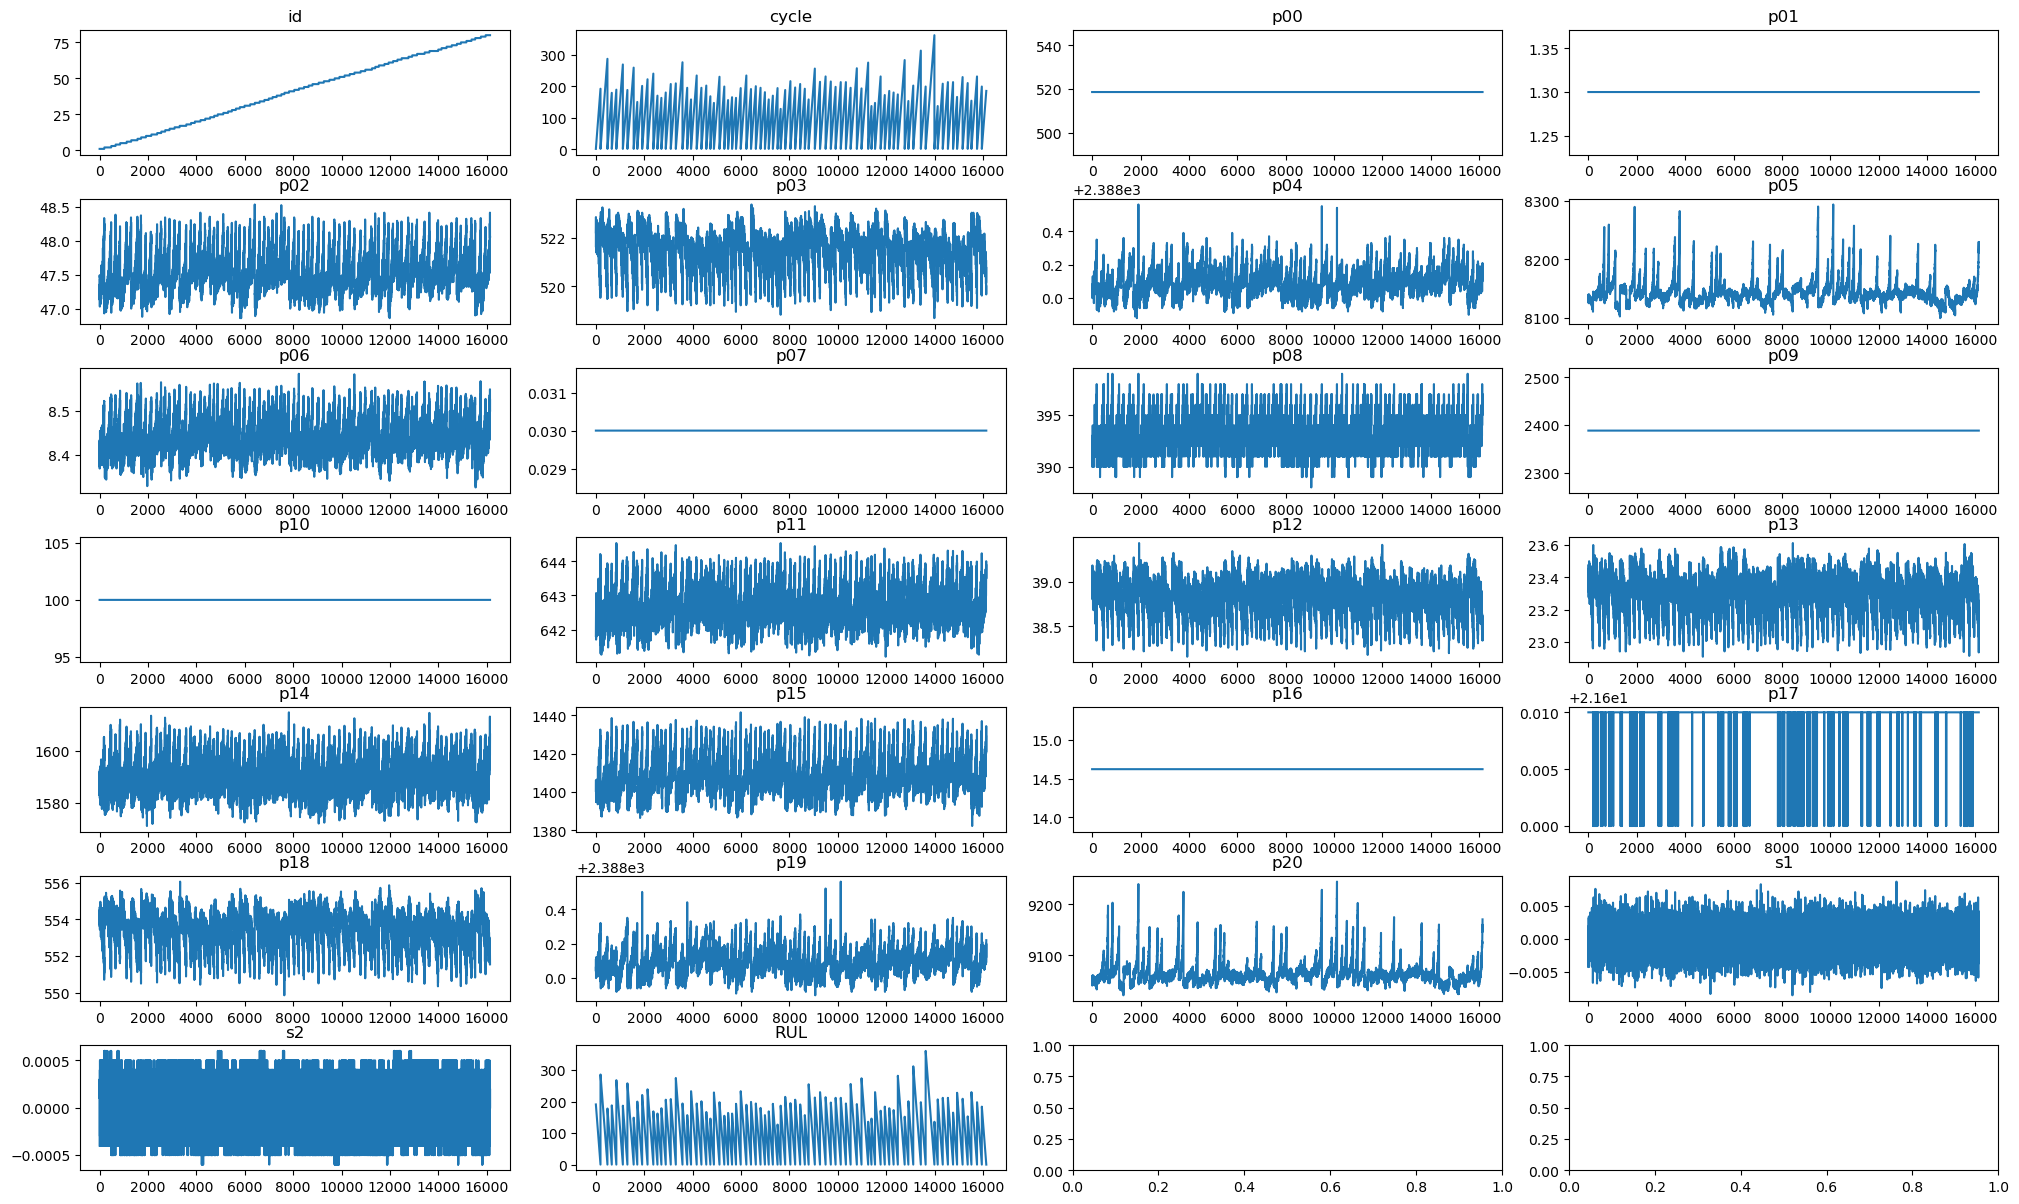

In [13]:
visualize_hist(df_new)

visualize_plot(df_new)

In [14]:
# Есть колонки с константными значениями, которые не принесут никакой пользы. От них можно спокойно избавиться. 
# Также есть колонки с выбросами. В зависимости от выбранной модели надо это учитывать.

In [15]:
# удаляем константные колонки
sens_const_values = []
for feature in df_new.columns:
    try:
        if df_new[feature].min()==df_new[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_new.drop(sens_const_values,axis=1,inplace=True)

['p00', 'p01', 'p07', 'p09', 'p10', 'p16']


In [16]:
df_new['p17'].unique()

array([21.61, 21.6 ])

In [17]:
# почти тоже самое, удаляем

df_new.drop('p17',axis=1,inplace=True)

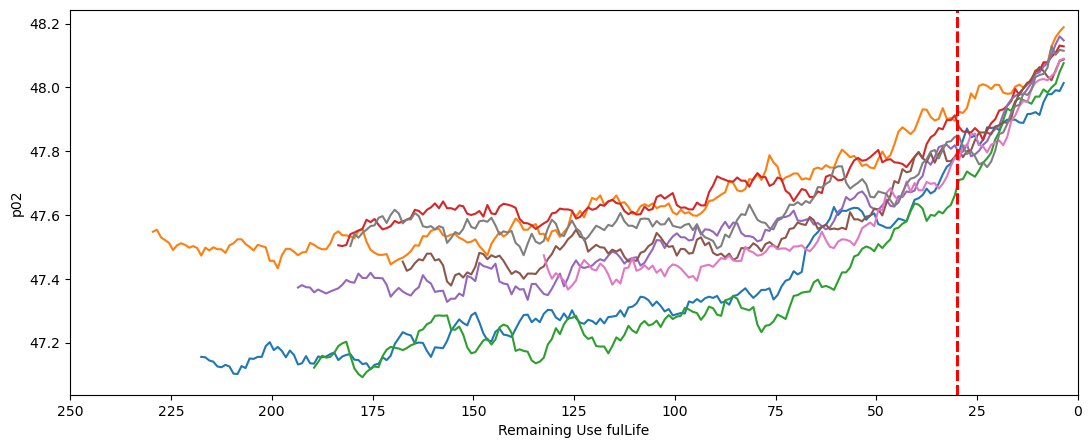

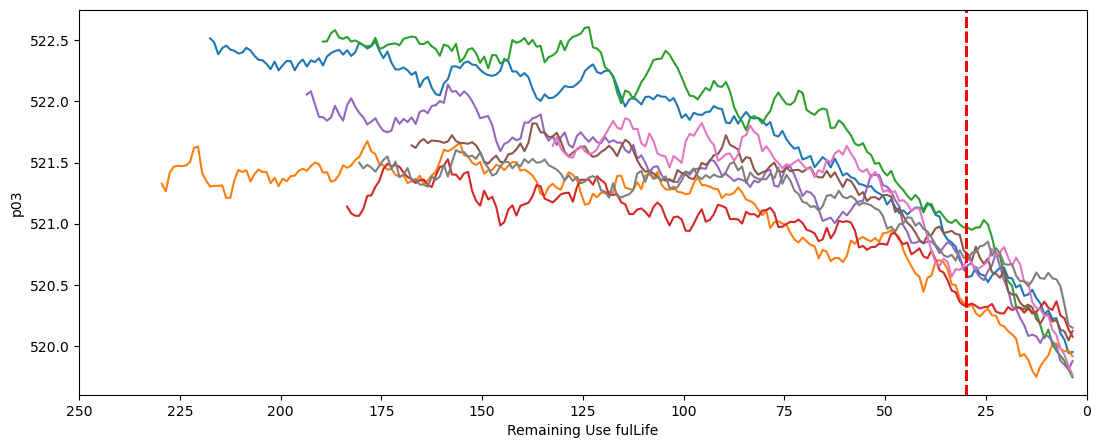

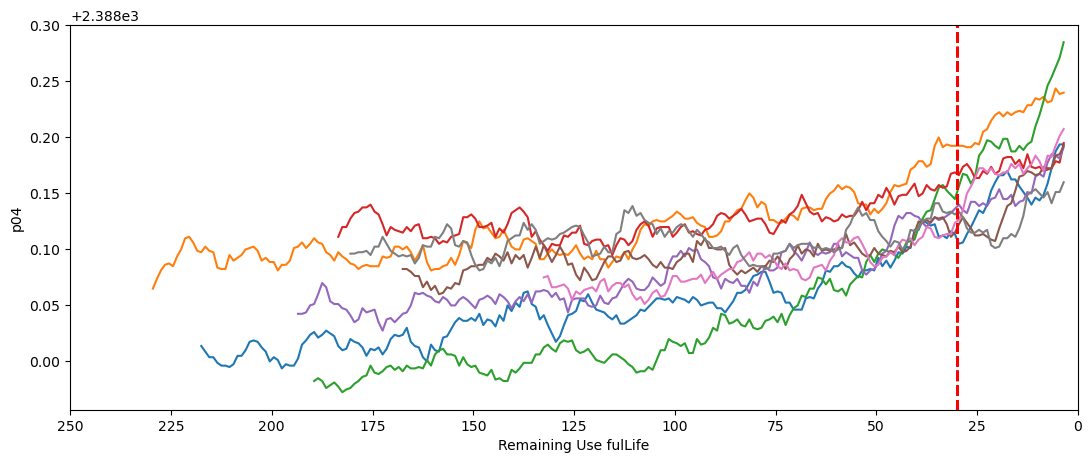

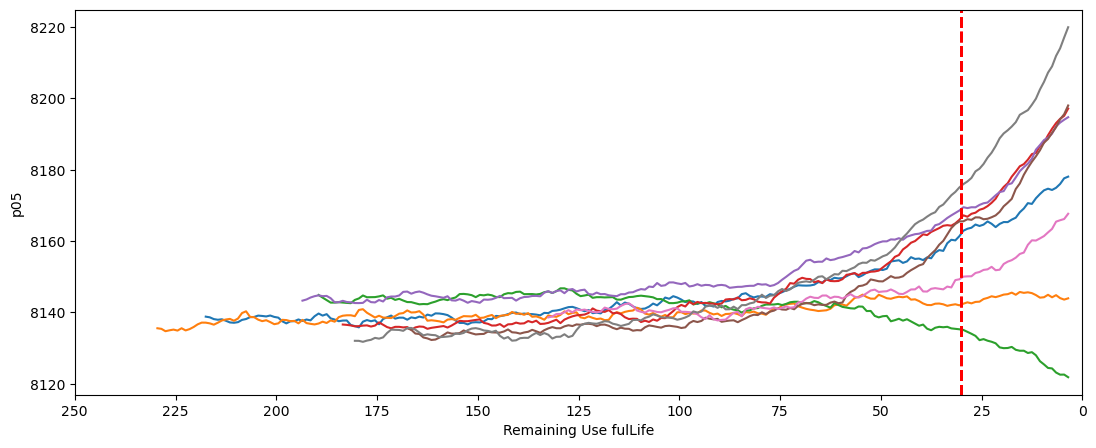

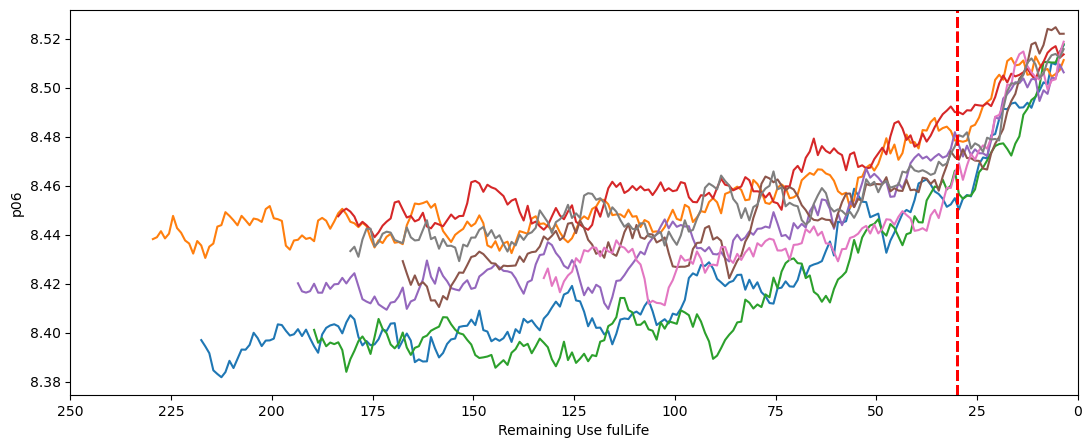

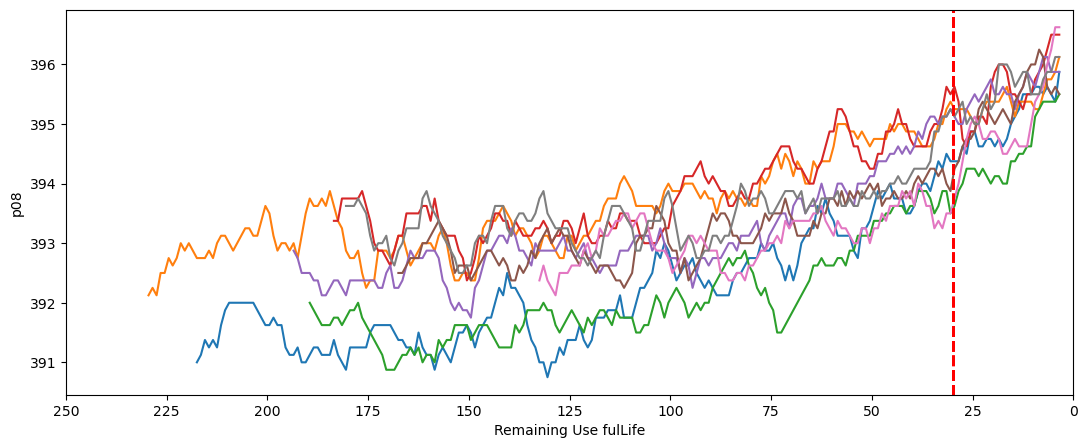

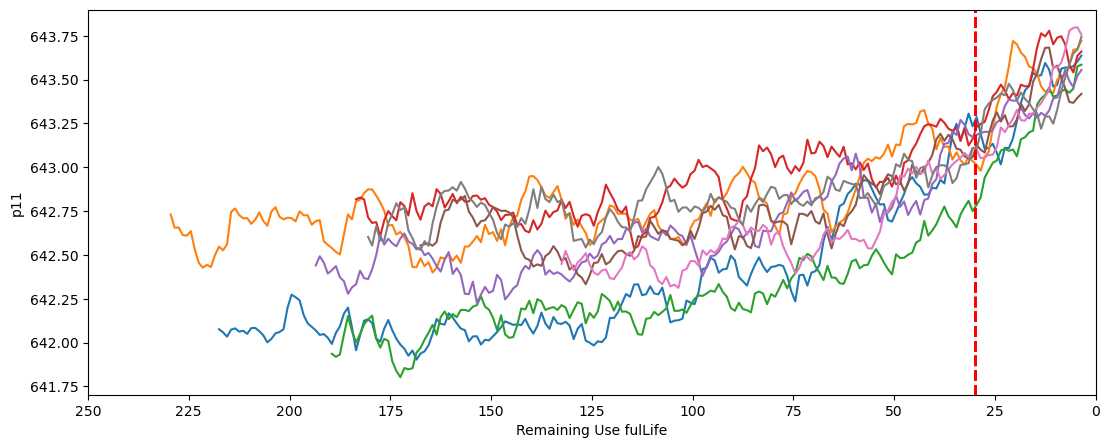

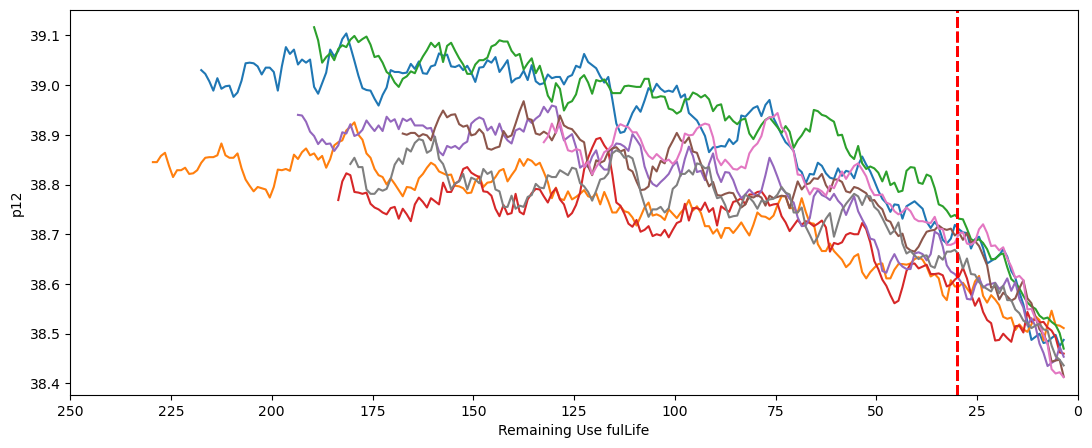

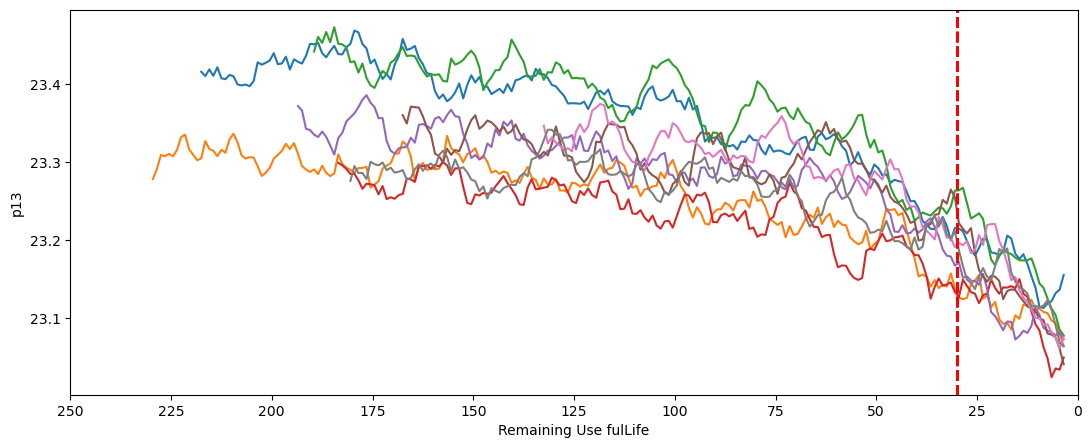

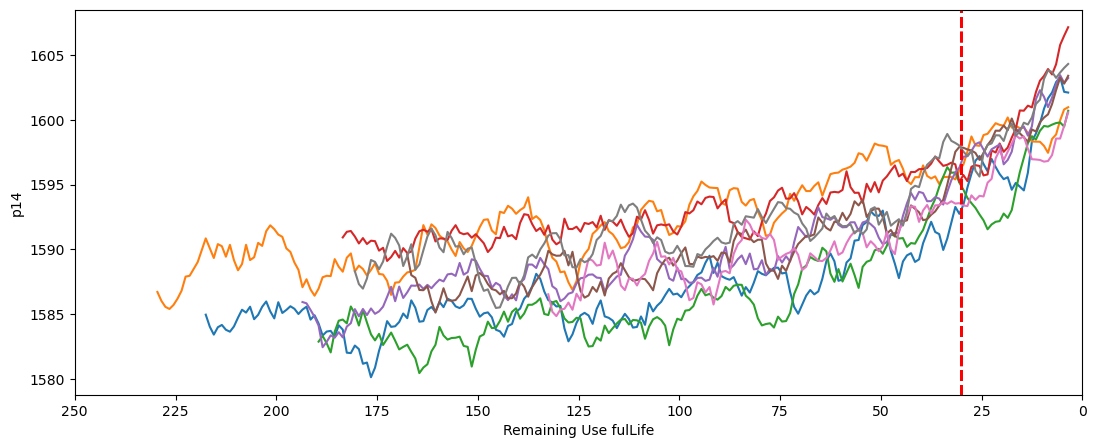

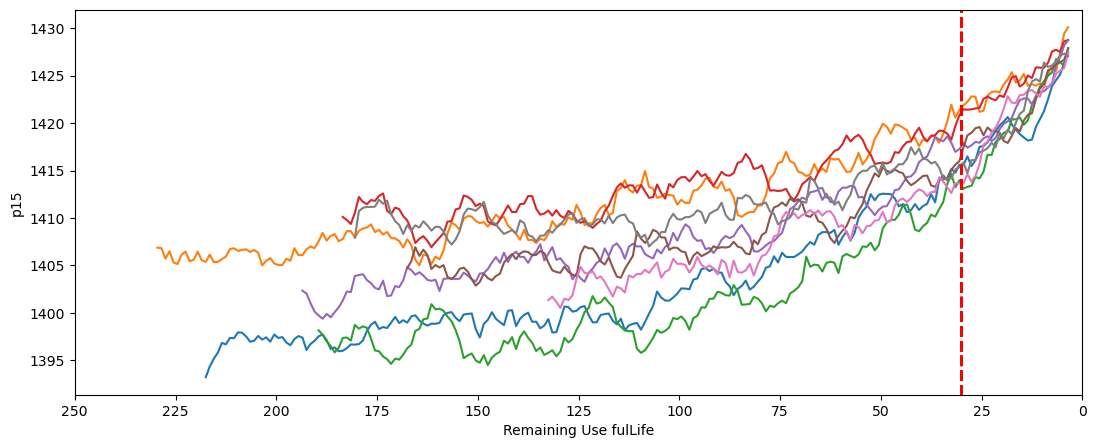

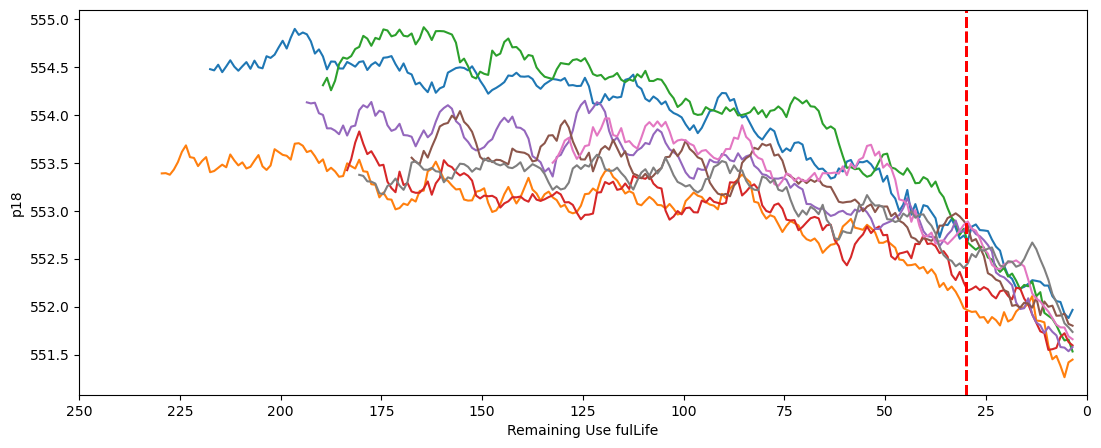

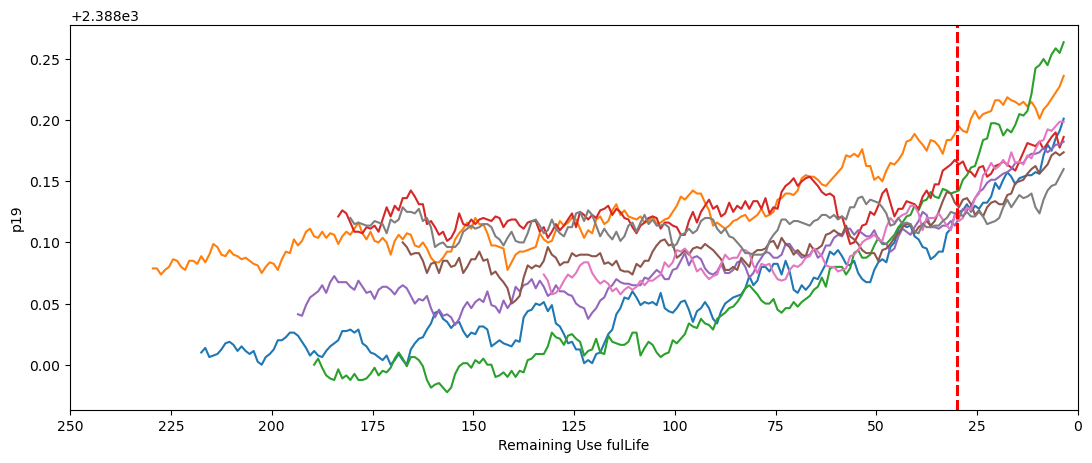

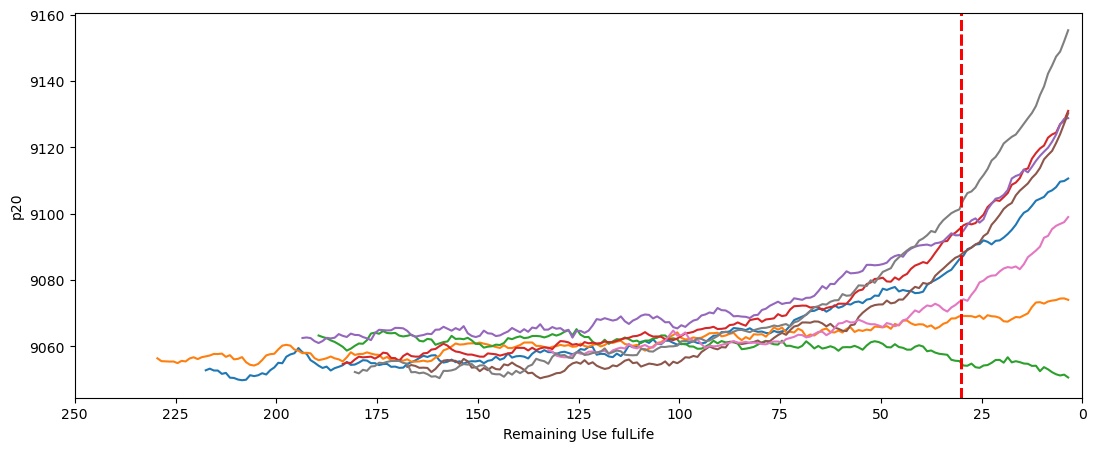

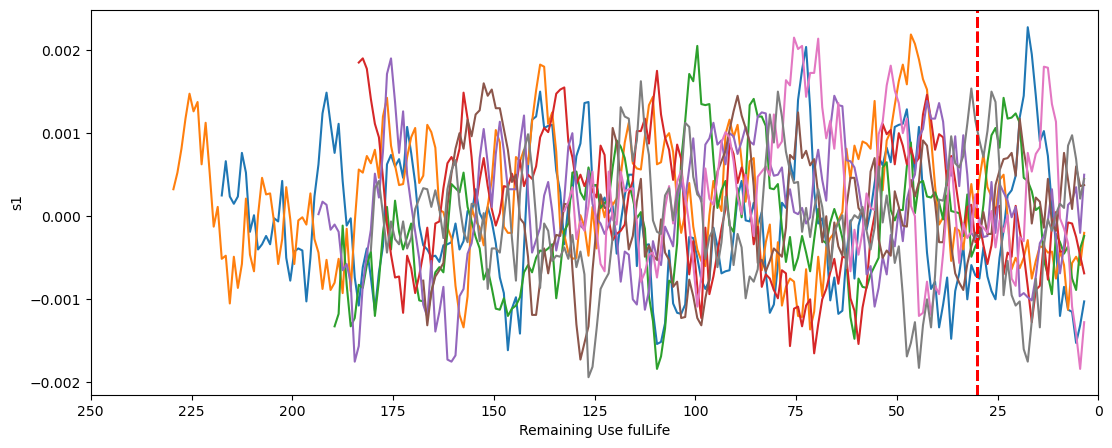

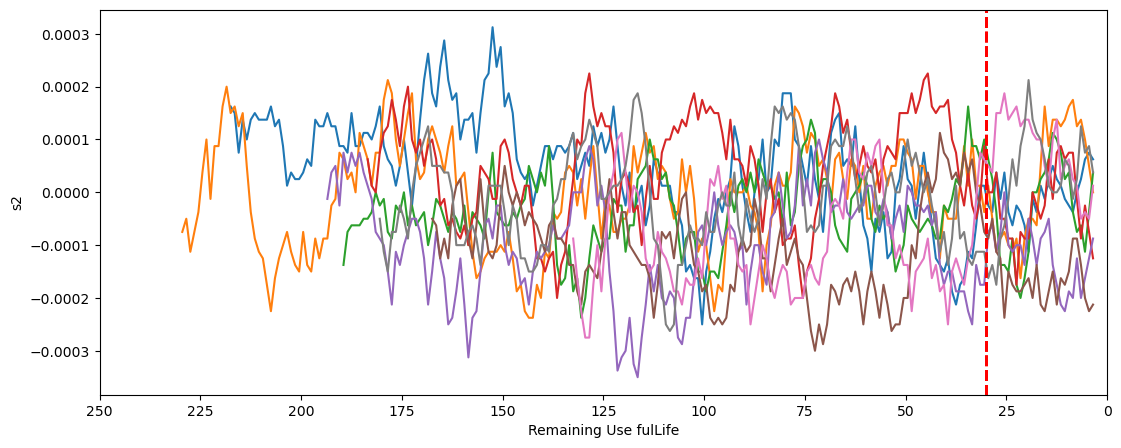

In [18]:
for feature in df_new.drop(['id', 'RUL', 'cycle'], axis=1).columns:
    plot_timeline(feature, df_new)

In [19]:
# визуально видно что s1, s2 в том виде в котором они есть сейчас несут только шум. 
# Если хотим их использовать понадобиться feture engineering для time-series. Как вариант можно попробовать преобразование Фурье.

In [20]:
drop_after_vis = ['s1', 's2']

df_last = df_new.drop(columns = drop_after_vis)

# Modeling

In [21]:
X = df_last.drop(columns = ['id', 'cycle', 'RUL'])
y = df_last['RUL']

In [22]:
X = remove_outlier(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# в тест закинуть движки которые не встречались в трейне!!!!!!!!

In [24]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [39]:
models = [LinearRegression(), RandomForestRegressor(), XGBRegressor()]

In [40]:
mses, rmses, r2s, maes = [], [], [], []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)  не правильно посчитал
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)
    maes.append(mae)
    
    
results = pd.DataFrame({'MSE':mses, 'RMSE':rmses, 'R2':r2s, 'MAE':maes})

In [41]:
results

,MSE,RMSE,R2,MAE
0,1563.720890,39.543911,0.621374,30.410693
1,1404.406784,37.475416,0.659949,26.814985
2,1512.233109,38.887442,0.633841,27.662637


In [21]:
# текущий 1, проработает 100, а модель предиктит что ему осталось жить 1 цикл ошибка мае 99/100 99%
# текущий 99, проработает 2, а модель предиктит что ему осталось жить 100 цикл ошибка мае 98/2 4900%


In [42]:
# Исходя из полученных результатов в базовой версии победил RandomForestRegressor.
# Я бы попробовал еще другие алгоритмы регрессии, но в этой задачи в качестве best model мы возьмем его.
# После этого этапа пойдет этап настройки гиперпараметров с помощью GridSearch или Optuna
# Интересно что данные объясняют примерно 65 процентов природы таргета, возможно стоит собрать больше данных или поиграться
# с feature engineering

Выводы. Бейзлайново мы получили модель которая предсказывает последний цикл с точностью +- 30 циклов. 
Достаточная ли это точность или нет - вопрос к бизнесу.
Задачу можно попробовать решить другим способом, а именно превратив ее в задачу классификации, создав бинарный таргет. Где 1 - факт поломки 0 - нет.
На практике данную модель можно использовать в качестве системы оповещения, где она будет кидать алерты что двигатель уже подходит к своей крайней точке. Построить систему мониторинга по каждому из датчиков, т.к. мы знаем что показатели некоторых из них высоко кореллируют с жизнеспособностью двигателей.